In [72]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from project_helpers import *

Extracting data

In [73]:
from project_helpers import get_dataset_info

K, img_names, init_pair, pixel_threshold = get_dataset_info(1)

def read_images(img_names):
  images = []
  for name in img_names:
    images.append((plt.imread(name) * 255).astype('uint8'))
  return images
  
img1 = (plt.imread('data/1/kronan1.jpg') * 255).astype('uint8')
img2 = (plt.imread('data/1/kronan2.jpg') * 255).astype('uint8')

print(img_names)

['data/1/kronan1.JPG', 'data/1/kronan2.JPG']


Getting 2D-points with SIFT

In [74]:
from cv2 import SIFT_create, cvtColor, COLOR_RGB2GRAY, FlannBasedMatcher, drawMatchesKnn
rgb2gray = lambda img: cvtColor(img, COLOR_RGB2GRAY)
sift = SIFT_create(contrastThreshold=0.02, edgeThreshold=10, nOctaveLayers=3)

# We detect keypoints and simultaneously describe them using SIFT
kp1, des1 = sift.detectAndCompute(rgb2gray(img1),None)
kp2, des2 = sift.detectAndCompute(rgb2gray(img2),None)

# We use a k-NN-like system to find the most similar descriptions
all_matches = FlannBasedMatcher().knnMatch(des1, des2, k=2)

# Apply ratio test
good_matches = []
for m,n in all_matches:
    if m.distance < 0.75*n.distance:
        good_matches.append([m])
        
# Supplied code for extracting numpy arrays from matching keypoints
# Note, x1 and x2 are in homogenous coordinates after this
x1 = np.array([[kp1[match[0].queryIdx].pt[0], kp1[match[0].queryIdx].pt[1]] for match in good_matches])
x2 = np.array([[kp2[match[0].trainIdx].pt[0], kp2[match[0].trainIdx].pt[1]] for match in good_matches])
x1 = np.vstack((x1.T, np.ones(x1.shape[0])))
x2 = np.vstack((x2.T, np.ones(x2.shape[0])))
xu = np.array([x1, x2])

x1_n = np.linalg.inv(K) @ x1
x2_n = np.linalg.inv(K) @ x2
xn = [x1_n, x2_n]

print(len(xn))
print(x1_n.shape)

2
(3, 18428)


In [ ]:
def img_pts(img1, kp1, des1, img2,K):
  kp2, des2 = sift.detectAndCompute(rgb2gray(img2),None)
  
  all_matches = FlannBasedMatcher().knnMatch(des1, des2, k=2)
  
  good_matches = []
  for m,n in all_matches:
      if m.distance < 0.75*n.distance:
          good_matches.append([m])
          
  x1 = np.array([[kp1[match[0].queryIdx].pt[0], kp1[match[0].queryIdx].pt[1]] for match in good_matches])
  x2 = np.array([[kp2[match[0].trainIdx].pt[0], kp2[match[0].trainIdx].pt[1]] for match in good_matches])
  x1 = np.vstack((x1.T, np.ones(x1.shape[0])))
  x2 = np.vstack((x2.T, np.ones(x2.shape[0])))

  x1_n = np.linalg.inv(K) @ x1
  x2_n = np.linalg.inv(K) @ x2
  
  return x1_n, x2_n

plot 10 random

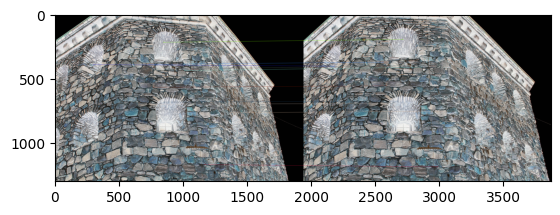

(<matplotlib.image.AxesImage at 0x1e3a9889670>, None)

In [76]:
idx = np.random.choice(len(matches), size=10, replace=False)
matches_array = np.array(matches)
selected_matches = matches_array[idx]

plt.figure()
img3 = drawMatchesKnn(img1,kp1,img2,kp2,selected_matches,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img3,),plt.show()

Estimating E robustly and extracting P fro E

In [77]:
threshold_px = 2
eps = threshold_px / K[0,0]
x1_k = np.linalg.inv(K) @ x1
x2_k = np.linalg.inv(K) @ x2
E_robust, inliers, errs, iters = estimate_E_robust(x1_k, x2_k, eps)
x1_inliers = inliers[:2]
x2_inliers = inliers[2:]

# Compute the essential matrix based on the keypoint matches we just computed between the two images

# Print the number of inliers

P2_extract = extract_P_from_E(E_robust)

P1_k = np.array([[1, 0, 0, 0],
               [0, 1, 0, 0],
               [0, 0, 1, 0]])

best_i = None
best_count = 0

for i in range(4):
    count = count_points_in_front(P1_k, P2_extract[i], x1_k, x2_k)
    if count > best_count:
        best_count = count
        best_i = i
    print(count)
    
print(best_i)

P2 = P2_extract[best_i]

#print(P2_extract)
#print(T)

# n = x1.shape[1] 
# points_3D = np.zeros((4,4,n))
# best_P = None

# for i in range(len(P_extract)):
#   for j in range(n):
#     points1 = x1_k[:,j]
#     points2 = x2_k[:,j]
#     points_3D[i][:,j] = triangulate_3D_point_DLT(points1,points2,P1_k,P_extract[i])
#     #count_points_in_front(points1,points2,P1_k,P_extract[i])
  
#   fig = plt.figure()
#   ax = fig.add_subplot(111, projection='3d')
#   #ax.scatter(points_3D[i][0], points_3D[i][1], points_3D[i][2], s=2, c='b')
#   ax.set_aspect('equal')
#   ax.set_xlabel('X')
#   ax.set_ylabel('Y')
#   ax.set_zlabel('Z')
#   plot_camera(P1_k, 1, ax)
#   plot_camera(P_extract[i], 1, ax)
  
#   ax.scatter(X[0, :], X[1, :], X[2, :], s=4, c='r', label='Original')
#   #ax.scatter(X_refined[0, :], X_refined[1, :], X_refined[2, :], s=2, c='b', label='Refined')
  
#   plt.show()

inliers 17899
0
0
79
18299
3


In [78]:
def get_RT(P1,x1,x2):
    threshold_px = 2
    eps = threshold_px / K[0,0]
    x1_k = np.linalg.inv(K) @ x1
    x2_k = np.linalg.inv(K) @ x2
    E_robust, inliers, errs, iters = estimate_E_robust(x1_k, x2_k, eps)
    x1_inliers = inliers[:2]
    x2_inliers = inliers[2:]

    # Compute the essential matrix based on the keypoint matches we just computed between the two images

    # Print the number of inliers

    P2_extract = extract_P_from_E(E_robust)  

    best_i = None
    best_count = 0

    for i in range(4):
        count = count_points_in_front(P1_k, P2_extract[i], x1_k, x2_k)
        if count > best_count:
            best_count = count
            best_i = i
        print(count)
        
    print(best_i)

    R = P2[:,:3]
    T = P2[:,3]
    return R, T

Calculate R, T from P

In [79]:
R = P2[:,:3]
T = P2[:,3]

print(R)
print(T)

[[ 0.99395031  0.02898903  0.10593592]
 [-0.03092756  0.99938207  0.01670199]
 [-0.10538629 -0.01987729  0.99423268]]
[-0.92065708 -0.13918091 -0.36471798]


(3, 18428)
(3, 18428)
(3, 4)
(3, 4)


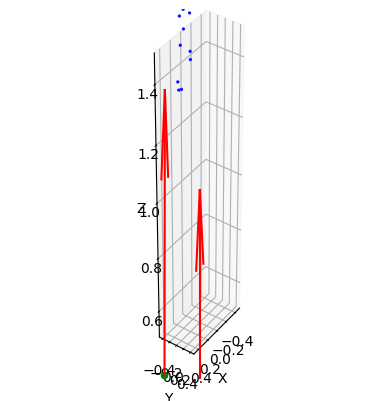

In [82]:
print(x1_k.shape)
print(x2_k.shape)
print(P1_k.shape)
print(P2.shape)

n = x1.shape[1] 
points_3D = np.zeros((4,n))
for i in range(n):
  points_3D[:,i] = triangulate_3D_point_DLT(x1_k[:,i],x2_k[:,i],P1_k,P2)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points_3D[0,:], points_3D[1,:], points_3D[2,:], s=2, c='b')
ax.set_aspect('equal')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.view_init(40, 35)
ax.set_xlim(-0.5, 0.5)
ax.set_ylim(-0.5, 0.5)
ax.set_zlim(0.5, 1.5)


plot_camera(K @ P1_k, 1, ax)
plot_camera(K @ P2, 1, ax)

plt.show()

In [81]:
def sfm(dataset_num):
  K, img_names, init_pair, pixel_threshold = get_dataset_info(dataset_num)
  images = read_images(img_names)
  cam_mats = [np.array([[1, 0, 0, 0],
                        [0, 1, 0, 0],
                        [0, 0, 1, 0]])]
  print(K)
  cam_mats_abs = [cam_mats[0]]
  for i in range(len(images)-1):
    x1, x2 = img_pts(images[i],images[i+1],K)
    R, T = get_RT(cam_mats[i],x1,x2)
    cam_mats.append([R,T])
    Ri_plus = cam_mats[i][0] @ cam_mats[i+1][0]
    Ti_plus = cam_mats[i][1] + cam_mats[i+1][1]
    cam_mats_abs.append([Ri_plus,Ti_plus])
    
  return cam_mats, cam_mats_abs

sfm(1)

[[2.48914286e+03 0.00000000e+00 9.68000000e+02]
 [0.00000000e+00 2.48914286e+03 6.48000000e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
inliers 18452
18452
18452
2778
15851
0


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 3 is different from 4)